## 1. Training Script for Multiclass Segmentation network
### 1.1 Setup
Run the following code cell before training.

In [5]:
import argparse
import logging
import os
import os.path as osp
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from unet import NestedUNet
from unet import UNet
from utils.dataset import BasicDataset

from losses import LovaszLossSoftmax
from losses import LovaszLossHinge
from losses import dice_coeff


def train_net(net, cfg):
    dataset = BasicDataset(cfg.images_dir, cfg.masks_dir, cfg.scale)

    val_percent = cfg.validation / 100
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train,
                              batch_size=cfg.batch_size,
                              shuffle=True,
                              num_workers=1,
                              pin_memory=True)
    val_loader = DataLoader(val,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            num_workers=1,
                            pin_memory=True)

    writer = SummaryWriter(comment=f'LR_{cfg.lr}_BS_{cfg.batch_size}_SCALE_{cfg.scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {cfg.epochs}
        Batch size:      {cfg.batch_size}
        Learning rate:   {cfg.lr}
        Optimizer:       {cfg.optimizer}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {cfg.save_cp}
        Device:          {device.type}
        Images scaling:  {cfg.scale}
    ''')

    if cfg.optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(),
                               lr=cfg.lr)
    elif cfg.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(),
                                  lr=cfg.lr,
                                  weight_decay=cfg.weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(),
                              lr=cfg.lr,
                              momentum=cfg.momentum,
                              weight_decay=cfg.weight_decay,
                              nesterov=cfg.nesterov)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=cfg.lr_decay_milestones,
                                               gamma = cfg.lr_decay_gamma)
    if cfg.n_classes > 1:
        criterion = LovaszLossSoftmax()
    else:
        criterion = LovaszLossHinge()

    for epoch in range(cfg.epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{cfg.epochs}', unit='img') as pbar:
            for batch in train_loader:
                batch_imgs = batch['image']
                batch_masks = batch['mask']
                assert batch_imgs.shape[1] == cfg.n_channels,\
                    f'Network has been defined with {cfg.n_channels} input channels, '\
                    f'but loaded images have {batch_imgs.shape[1]} channels. Please check that '\
                    'the images are loaded correctly.'

                batch_imgs = batch_imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
                batch_masks = batch_masks.to(device=device, dtype=mask_type)

                inference_masks = net(batch_imgs)

                if cfg.n_classes == 1:
                    inferences = inference_masks.squeeze(1)
                    masks = batch_masks.squeeze(1)
                else:
                    inferences = inference_masks
                    masks = batch_masks

                if cfg.deepsupervision:
                    loss = 0
                    for inference_mask in inferences:
                        loss += criterion(inference_mask, masks)
                    loss /= len(inferences)
                else:
                    loss = criterion(inferences, masks)

                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)
                writer.add_scalar('model/lr', optimizer.param_groups[0]['lr'], global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                pbar.update(batch_imgs.shape[0])
                global_step += 1

                if global_step % (len(dataset) // (10 * cfg.batch_size)) == 0:
                    val_score = eval_net(net, val_loader, device, n_val, cfg)
                    if cfg.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('CrossEntropy/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', batch_imgs, global_step)
                    if cfg.deepsupervision:
                        inference_masks = inference_masks[-1]
                    if cfg.n_classes == 1:
                        # writer.add_images('masks/true', batch_masks, global_step)
                        inference_mask = torch.sigmoid(inference_masks) > cfg.out_threshold
                        writer.add_images('masks/inference',
                                          inference_mask,
                                          global_step)
                    else:
                        # writer.add_images('masks/true', batch_masks, global_step)
                        ids = inference_masks.shape[1]  # N x C x H x W
                        inference_masks = torch.chunk(inference_masks, ids, dim=1)
                        for idx in range(0, len(inference_masks)):
                            inference_mask = torch.sigmoid(inference_masks[idx]) > cfg.out_threshold
                            writer.add_images('masks/inference_'+str(idx),
                                              inference_mask,
                                              global_step)
        if cfg.save_cp:
            try:
                os.mkdir(cfg.checkpoints_dir)
                logging.info('Created checkpoint directory')
            except OSError:
                pass

            ckpt_name = 'epoch_' + str(epoch + 1) + '.pth'
            torch.save(net.state_dict(),
                       osp.join(cfg.checkpoints_dir, ckpt_name))
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()


def eval_net(net, loader, device, n_val, cfg):
    """
    Evaluation without the densecrf with the dice coefficient

    """
    net.eval()
    tot = 0

    with tqdm(total=n_val, desc='Validation round', unit='img', leave=False) as pbar:
        for batch in loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
            true_masks = true_masks.to(device=device, dtype=mask_type)

            # compute loss
            if cfg.deepsupervision:
                masks_preds = net(imgs)
                loss = 0
                for masks_pred in masks_preds:
                    tot_cross_entropy = 0
                    for true_mask, pred in zip(true_masks, masks_pred):
                        pred = (pred > cfg.out_threshold).float()
                        if cfg.n_classes > 1:
                            sub_cross_entropy = F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                        else:
                            sub_cross_entropy = dice_coeff(pred, true_mask.squeeze(dim=1)).item()
                        tot_cross_entropy += sub_cross_entropy
                    tot_cross_entropy = tot_cross_entropy / len(masks_preds)
                    tot += tot_cross_entropy
            else:
                masks_pred = net(imgs)
                for true_mask, pred in zip(true_masks, masks_pred):
                    pred = (pred > cfg.out_threshold).float()
                    if cfg.n_classes > 1:
                        tot += F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                    else:
                        tot += dice_coeff(pred, true_mask.squeeze(dim=1)).item()

            pbar.update(imgs.shape[0])
    return tot / n_val

### 1.2 Configurations
Edit the following `__init__` of the following class for configuration of the network.

In [44]:
from config import UNetConfig, RAW_DATA, CLAHE_DATA, NLMEANS_DATA, ESRGAN_DATA


class NetworkConfig(UNetConfig):

    def __init__(self,
                 epochs = 50,  # Number of epochs
                 batch_size = 1,    # Batch size
                 validation = 10.0,   # Percent of the data that is used as validation (0-100)
                 out_threshold = 0.5,

                 optimizer='Adam',
                 lr = 0.0001,     # learning rate
                 lr_decay_milestones = [20, 50],
                 lr_decay_gamma = 0.9,
                 weight_decay=1e-8,
                 momentum=0.9,
                 nesterov=True,

                 n_channels = 1, # Number of channels in input images
                 n_classes = 8,  # Number of classes in the segmentation
                 scale = 1,    # Downscaling factor of the images

                 load = False,   # Load model from a .pth file
                 save_cp = True,
                 load_directory = CLAHE_DATA,

                 model='UNet',
                 bilinear = True,
                 deepsupervision = False,
                  ):
            super().__init__(epochs, batch_size, validation, out_threshold,
                             optimizer, lr, lr_decay_milestones, lr_decay_gamma, weight_decay, momentum, nesterov, n_channels, n_classes, scale, load, save_cp, model, bilinear, deepsupervision)
            self.images_dir = os.path.join(load_directory, "images")
            self.masks_dir = os.path.join(load_directory, "masks")
            self.checkpoints_dir = os.path.join(load_directory, "checkpoints")
            self.data = load_directory
            os.makedirs(self.checkpoints_dir, exist_ok=True)

### 1.3 Training
Run the following code block for training the multiclass segmentation network.

In [ ]:
cfg = NetworkConfig()
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
logging.info(f'Using device {device}')

net = eval(cfg.model)(cfg)
logging.info(f'Network:\n'
             f'\t{cfg.model} model\n'
             f'\t{cfg.n_channels} input channels\n'
             f'\t{cfg.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if cfg.bilinear else "Dilated conv"} upscaling')

if cfg.load:
    net.load_state_dict(
        torch.load(cfg.load, map_location=device)
    )
    logging.info(f'Model loaded from {cfg.load}')

net.to(device=device)
# faster convolutions, but more memory
# cudnn.benchmark = True

try:
    train_net(net=net, cfg=cfg)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)

Epoch 1/50:   0%|          | 1/995 [00:20<5:42:48, 20.69s/img, loss (batch)=0.85] 

## 2. Testing
The following script can be used to use the before trained model for new images.
### 2.1 Setup
Run the following cell before running the script. This script uses the configurations from the training part.

In [41]:
import argparse
import logging
import os
import os.path as osp
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from unet import NestedUNet
from unet import UNet
from utils.dataset import BasicDataset
from utils.colors import get_colors
from config import UNetConfig
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

def inference_one(net, image, device):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(image, cfg.scale))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        if cfg.deepsupervision:
            output = output[-1]

        if cfg.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((image.size[1], image.size[0])),
                transforms.ToTensor()
            ]
        )

        if cfg.n_classes == 1:
            probs = tf(probs.cpu())
            mask = probs.squeeze().cpu().numpy()
            return mask > cfg.out_threshold
        else:
            masks = []
            for prob in probs:
                prob = tf(prob.cpu())
                mask = prob.squeeze().cpu().numpy()
                mask = mask > cfg.out_threshold
                masks.append(mask)
            return masks

cfg = NetworkConfig()

def clahe(img):
    cv_format = np.array(img)
    clahe_obj = cv2.createCLAHE()
    clahe_img = clahe_obj.apply(cv_format)
    return Image.fromarray(clahe_img)

def nlmeans(img):
    cv_format = np.array(img)
    nlmeans_img = cv2.fastNlMeansDenoising(cv_format, h=10)
    return Image.fromarray(nlmeans_img)

def raw(img):
    return img

class args:
    data = cfg.data
    model = os.path.join(data, "checkpoints", "epoch_50.pth")
    output = os.path.join(data, "inference")
    preprocessing = nlmeans

### 2.2 Inference
Run the following cell the use inference for a few images. The images will be saved in the a folder called "inference" in the original dataset folder.

In [42]:
from tkinter import Tk, filedialog
import cv2

os.makedirs(args.output, exist_ok=True)
# Get the files which should be inferred
root = Tk()
root.withdraw() # Hide the main window.
input_imgs = filedialog.askopenfilename(multiple=True)
cfg = NetworkConfig()
net = eval(cfg.model)(cfg)
logging.info("Loading model {}".format(args.model))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(args.model, map_location=device))

logging.info("Model loaded !")
originals = []
outputs = []
for i, img_name in tqdm(enumerate(input_imgs)):
    logging.info("\nPredicting image {} ...".format(img_name))

    img_path = img_name
    print(img_name)
    img = Image.open(img_path).convert('L')
    img = args.preprocessing(img)
    originals.append(img)
    mask = inference_one(net=net,
                         image=img,
                         device=device)
    output_img_dir = args.output
    os.makedirs(output_img_dir, exist_ok=True)

    if cfg.n_classes == 1:
        image_idx = Image.fromarray((mask * 255).astype(np.uint8))
        outputs.append(image_idx)
        image_idx.save(osp.join(output_img_dir, img_name))
    else:
        colors = get_colors(n_classes=cfg.n_classes)
        w, h = img.size
        img_mask = np.zeros([h, w, 3], np.uint8)
        for idx in range(0, len(mask)):
            image_idx = Image.fromarray((mask[idx] * 255).astype(np.uint8))
            array_img = np.asarray(image_idx)
            img_mask[np.where(array_img==255)] = colors[idx]
        img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
        img_mask = cv2.cvtColor(np.asarray(img_mask),cv2.COLOR_RGB2BGR)
        output = cv2.addWeighted(img, 0.7, img_mask, 0.3, 0)
        outputs.append(output)
        cv2.imwrite(osp.join(output_img_dir, (img_name.rsplit(sep="/"))[-1]), output)

0it [00:00, ?it/s]

D:/DFKI/ophthalmo-ai-datasets/Datasets/Kaggle/OCT/OCT2017/train/DRUSEN/DRUSEN-95633-19.jpeg


1it [00:01,  1.61s/it]


### 2.3 Visualization
The following code cell plots the original images versus the predicted segmentation.

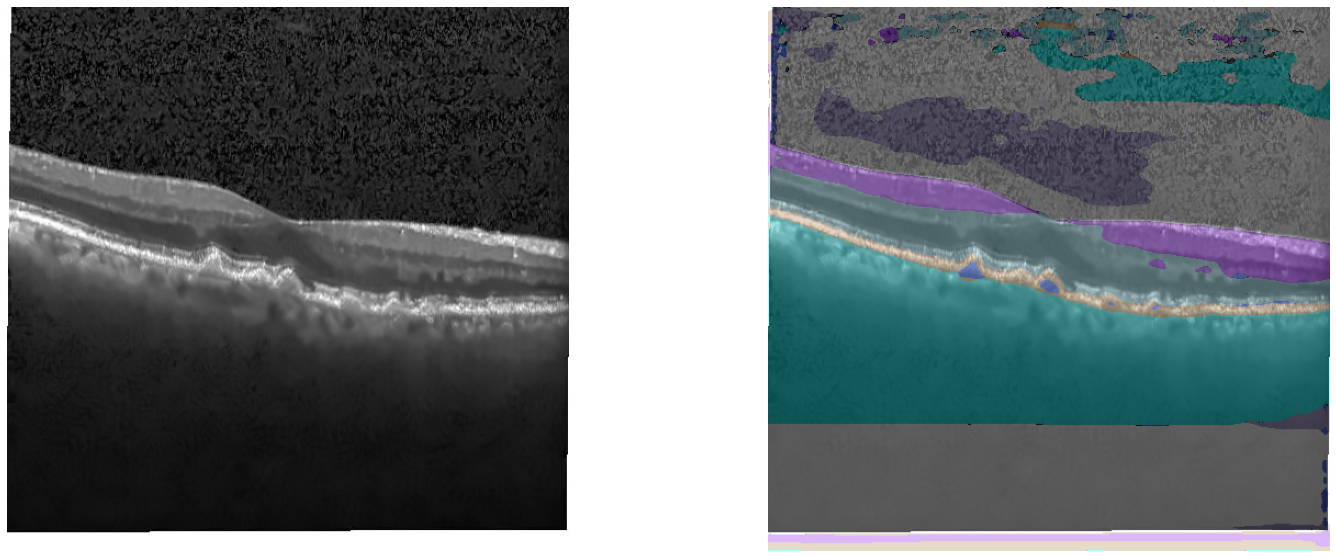

In [43]:
import matplotlib.pyplot as plt

rows = len(originals)
plt.figure(figsize=(25, rows * 10))
counter = 1
for i in range(rows):
    plt.subplot(rows, 2, counter)
    plt.axis("off")
    plt.imshow(originals[i], cmap='gray', vmin=0, vmax=255)
    plt.subplot(rows, 2, counter + 1)
    plt.axis("off")
    plt.imshow(outputs[i])
    counter += 2
plt.show()